# Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

seed=99
random.seed(seed)
np.random.seed(seed)

## Load Datasets

**Morocco**
head, tail. 
granularity: 10 minutes

**USA**  
head:2004-01-01 00:00:00, tail: 2008-06-30 23:00:00	  
granularity: hourly  
Features: Consumption, Temperature
Temp has 18 missing values. These are the last 18 records  
size: 39432 hours

**Paraguay**  
head: 2017-01-01 00:00:00, tail: 2020-12-31 23:00:00  
granularity: hourly  
0 missing values, 792 rows where consumption is 0.0 the last 360 values are part of this  
35064 hours

In [14]:
paraguay = pd.read_csv("../data/raw/paraguay.csv")

In [22]:
paraguay[paraguay['Consumption'] == 0]

,DateTime,Consumption,Temperature
2160,2017-04-01 00:00:00,0.0,20.533333
2161,2017-04-01 01:00:00,0.0,20.266667
2162,2017-04-01 02:00:00,0.0,20.000000
2163,2017-04-01 03:00:00,0.0,19.466667
2164,2017-04-01 04:00:00,0.0,18.933333
...,...,...,...
35059,2020-12-31 19:00:00,0.0,28.800000
35060,2020-12-31 20:00:00,0.0,26.000000
35061,2020-12-31 21:00:00,0.0,25.600000
35062,2020-12-31 22:00:00,0.0,25.000000


In [49]:
morocco = pd.read_csv("../data/raw/morocco.csv")
usa = pd.read_csv("../data/raw/usa.csv")
paraguay = pd.read_csv("../data/raw/paraguay.csv")
#spain_cities_energy = pd.read_csv("../data/raw/spain_cities/energy_dataset.csv")
#spain_cities_weather = pd.read_csv("../data/raw/spain_cities/weather_features.csv")
#spain_houses = pd.read_excel("../data/raw/spain_houses/20201015_consumption.xlsx")

#morocco = pd.read_csv('morocco.csv')
#paraguay = pd.read_csv('paraguay.csv')
#spain_cities_average = pd.read_csv('spain_cities_average.csv')
#barcelona = pd.read_csv('spain_cities_barcelona.csv')
#bilbao = pd.read_csv('spain_cities_bilbao.csv')
#madrid = pd.read_csv('spain_cities_madrid.csv')
#seville = pd.read_csv('spain_cities_seville.csv')
#valencia = pd.read_csv('spain_cities_valencia.csv')
#spain_houses = pd.read_csv('spain_houses.csv')
#usa = pd.read_csv('usa.csv')

# remove missing data from end of datasets since we cant linear interpolate it
usa = usa.iloc[:-18]
paraguay = paraguay.iloc[:-360]
datasets = {'morocco': morocco, 'paraguay': paraguay, 'spain_cities_average': spain_cities_average, 'barcelona': barcelona, 'bilbao': bilbao, 'madrid': madrid, 'seville': seville, 'valencia': valencia, 'spain_houses': spain_houses, 'usa': usa}
datasets_electricity = {'morocco': morocco, 'paraguay': paraguay, 'spain_cities_average': spain_cities_average, 'spain_houses': spain_houses, 'usa': usa}

Impute missing values:  

In [53]:
print('missing values:')
print('morocco:', morocco.isnull().sum().sum())
print('usa:', usa.isnull().sum().sum())
print('paraguay:', paraguay.isnull().sum().sum())
#print('spain_cities_energy:', spain_cities_energy.isnull().sum().sum())
#print('spain_cities_weather:', spain_cities_weather.isnull().sum().sum())
#print('spain_houses:', spain_houses.isnull().sum().sum())

missing values:
morocco: 0
usa: 18
paraguay: 0


Morocco is not missing any values

Usa data:  
We can see that we are missing some values in the `Temperature` feature. In order to fill in these values we can impute them by the average of the values before and after to simulate a natural change in temperature. We can implement a custom function that finds the missing values, identifies the nearest non-missing values, calculates their average and fill in the missing value with the result, but there already exists some functionality to do almost the same. 

After further analysis we can see that the 18 missing values are the last 18 observations in the time series.

In [5]:
usa = usa[:-18] # Remove 18 last entries

Check for outliers with DBSCAN  

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm used also for outlier detection. It works well when you have clusters of varying shapes and sizes, and it can identify points that do not belong to any cluster as outliers.

params
* eps (the maximum distance between two samples for them to be considered as in the same neighborhood)
* min_samples (the number of samples in a neighborhood for a point to be considered as a core point).

Outliers:
 Empty DataFrame
Columns: [Consumption, Temperature, Humidity, Wind Speed, general diffuse flows, diffuse flows, Cluster]
Index: []


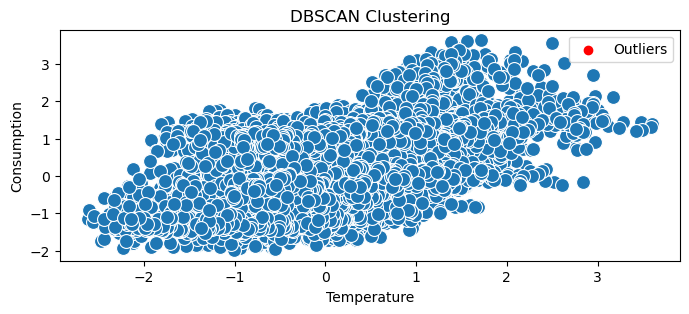

In [45]:
data=morocco_processed
# Optional: Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Temperature', 'Consumption']])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data_scaled)

# Add the cluster labels to your original DataFrame
data['Cluster'] = clusters

# Identify outliers
outliers = data[data['Cluster'] == -1]
print("Outliers:\n", outliers)

# You can also examine the clusters formed
#print("Clustered Data:\n", data[data['Cluster'] != -1])

# Plotting
plt.figure(figsize=(8, 3))
# Plot clusters
sns.scatterplot(x=data_scaled[:, 0], y=data_scaled[:, 1], legend='full', s=100)
# Plot outliers
outliers = data_scaled[clusters == -1]
plt.scatter(outliers[:, 0], outliers[:, 1], color='red', label='Outliers')
plt.legend()
plt.title('DBSCAN Clustering')
plt.xlabel('Temperature')
plt.ylabel('Consumption')
plt.show()

From the above plot, we see that we have no outliers in the temperature and consumption values.

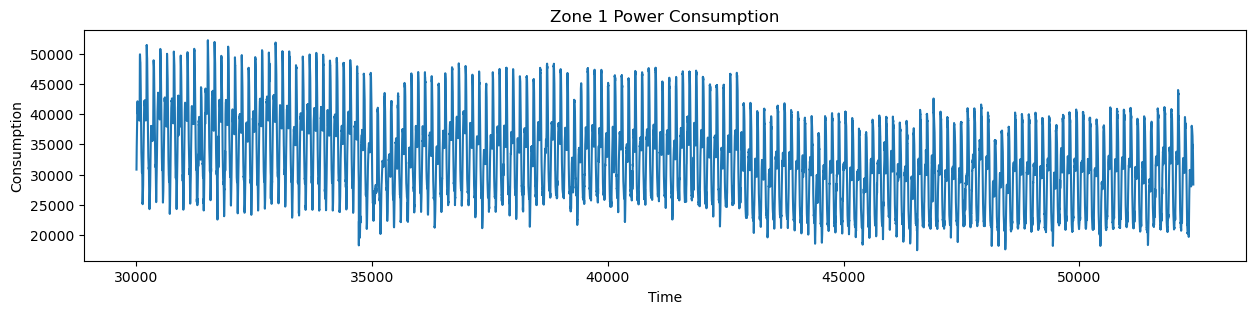

In [54]:
morocco['Zone 1 Power Consumption'][30000:].plot(kind='line', figsize=(15, 3), title='Zone 1 Power Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

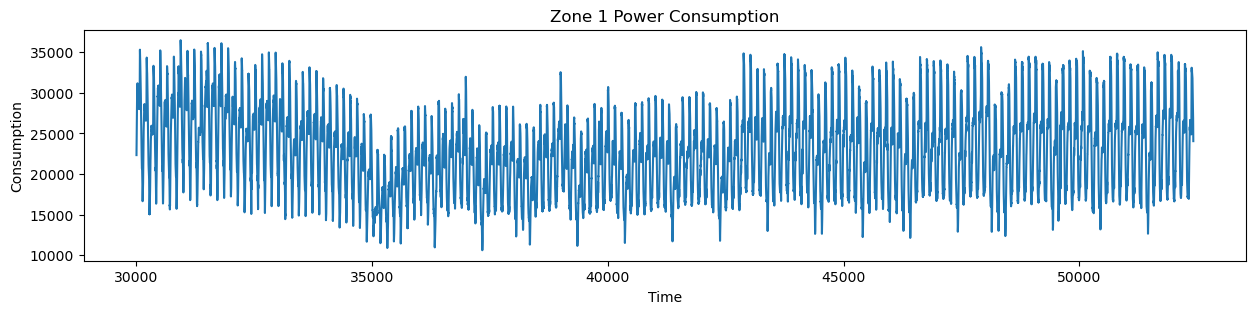

In [55]:
morocco['Zone 2  Power Consumption'][30000:].plot(kind='line', figsize=(15, 3), title='Zone 1 Power Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

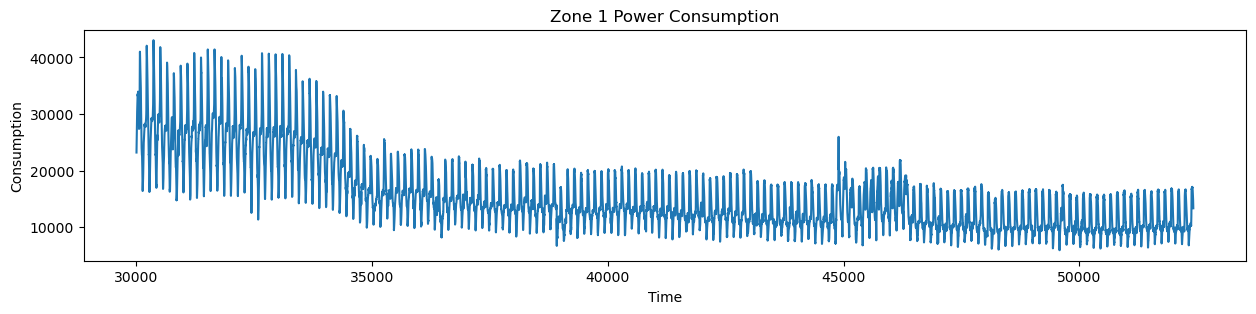

In [56]:
morocco['Zone 3  Power Consumption'][30000:].plot(kind='line', figsize=(15, 3), title='Zone 1 Power Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

In [57]:
morocco['Consumption'] = morocco['Zone 1 Power Consumption'] + morocco['Zone 2  Power Consumption'] + morocco['Zone 3  Power Consumption']
morocco = morocco.drop(['Zone 1 Power Consumption','Zone 2  Power Consumption', 'Zone 3  Power Consumption'], axis=1)

In [58]:
morocco['DateTime'] = pd.to_datetime(morocco['DateTime'], format='%m/%d/%Y %H:%M')

### Resampling
Currently the data has data in different frequencies.

In [59]:
morocco.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Consumption'],
      dtype='object')

In [60]:
# Sum up the dataframe for each hour
agg_methods = {
    'Consumption': 'sum',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Wind Speed': 'mean',
    'general diffuse flows': 'mean',
    'diffuse flows': 'mean',
}
morocco_processed = morocco.groupby(morocco["DateTime"].dt.floor('h')).agg(agg_methods)

In [61]:
print(morocco.shape)
print(morocco_processed.shape) # lost feature due to DateTime becoming index

(52416, 7)
(8736, 6)


In [62]:
morocco_processed.head()

,Consumption,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows
DateTime,,,,,,
2017-01-01 00:00:00,398860.62358,6.196833,75.066667,0.081833,0.063500,0.098833
2017-01-01 01:00:00,346671.15726,5.548833,77.583333,0.082000,0.056833,0.112500
2017-01-01 02:00:00,312539.28984,5.054333,78.933333,0.082333,0.063000,0.129167
2017-01-01 03:00:00,293486.68529,5.004333,77.083333,0.082833,0.059833,0.141000
2017-01-01 04:00:00,286287.83008,5.097667,74.050000,0.082333,0.058000,0.122833


In [ ]:
if False:
    morocco['year'] = morocco['DateTime'].dt.year
    morocco['month'] = morocco['DateTime'].dt.month
    morocco['day'] = morocco['DateTime'].dt.day
    morocco['hour'] = morocco['DateTime'].dt.hour
    morocco.set_index('DateTime', inplace=True)

In [63]:
print('null values:',morocco.isnull().sum().sum())
print('columns with inf values:', morocco.columns.to_series()[np.isinf(morocco).any()])

null values: 0
columns with inf values: Series([], dtype: object)


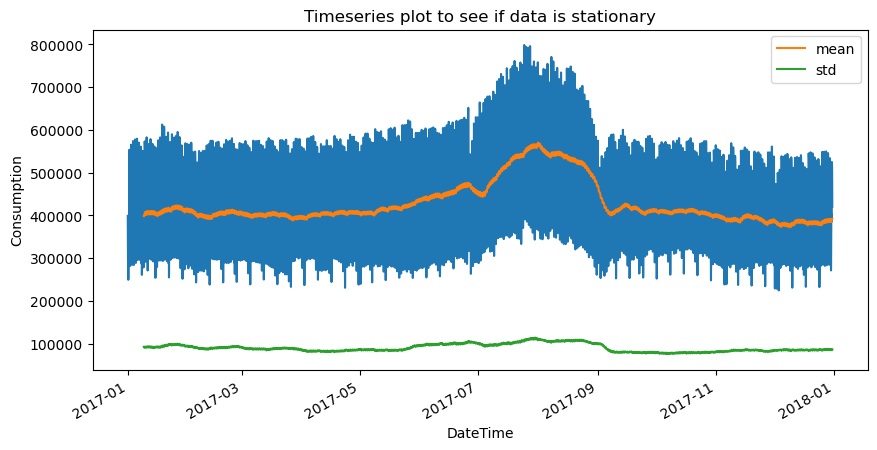

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=morocco_processed,x=morocco_processed.index,y=morocco_processed.Consumption)
morocco_processed.Consumption.rolling(window=200).mean().plot(label='mean')
morocco_processed.Consumption.rolling(window=200).std().plot(label='std')
plt.title('Timeseries plot to see if data is stationary')

ax.legend()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [65]:
morocco_processed.head()

,Consumption,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows
DateTime,,,,,,
2017-01-01 00:00:00,398860.62358,6.196833,75.066667,0.081833,0.063500,0.098833
2017-01-01 01:00:00,346671.15726,5.548833,77.583333,0.082000,0.056833,0.112500
2017-01-01 02:00:00,312539.28984,5.054333,78.933333,0.082333,0.063000,0.129167
2017-01-01 03:00:00,293486.68529,5.004333,77.083333,0.082833,0.059833,0.141000
2017-01-01 04:00:00,286287.83008,5.097667,74.050000,0.082333,0.058000,0.122833


### Transformation

Transform and scale the data: stationary, normalized, standardized
https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/

If the distribution of the quantity is normal, then it should be standardized, 
otherwise the series should be normalized.

Min-max scaling: rescale the data from its original range to the range between 0 and 1.
Normalization helps in speeding up the training and can lead to a faster convergence.
Make sure to inverse the transform after making a prediction for plotting and reporting

Standardizing a dataset involves rescaling the distribution of values
so that the mean of observed values is 0 and the standard deviation is 1.
Standardization assumes that your observations fit a Gaussian distribution (bell curve)
with a well behaved mean and standard deviation.
You can still standardize your time series data if this expectation is not met, 
but you may not get reliable results.

Categorical features: Perform integer encoding, then one-hot encoding

Scaling the output variable (the variable predicted by the network). Ensure that the scale of your output variable matches the scale of the activation function (transfer function) on the output layer of your network.

In [63]:
from sklearn.preprocessing import MinMaxScaler

# Reshape data for normalization?

# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(morocco) # Where X = morocco

# normalize the dataset and print
morocco_normalized = scaler.transform(morocco)

# inverse transform and print: inversed = scaler.inverse_transform(normalized)

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(values)
standardized = scaler.transform(values)

In [ ]:
# Add features
from feature_extraction import add_volatility_feature

In [67]:
morocco_processed.to_csv('../data/processed/morocco_processed.csv')

In [ ]:
usa.to_csv('../data/processed/usa_processed.csv')

In [ ]:
paraguay.to_csv('../data/processed/paraguay_processed.csv')

In [ ]:
spain_cities.to_csv('../data/processed/spain_cities_processed.csv')

In [ ]:
spain_houses.to_csv('../data/processed/spain_houses_processed.csv')